In [8]:
from sklearn.preprocessing import MinMaxScaler 
from transformer_encoder_decoder_qr_model import TransformerEncoderDecoderQRModel

from utils import *

import random 
import os
import sys 

In [9]:
nhead =  4      # number of heads in the multi-head attention models
d_model = 64 #32    # model dimension
d_hid = 128 #64      # dimension of the feedforward network model
nlayers = 2 #4 #2     # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
dropout = 0.1   # dropout rate

input_length  = 4  # Number of data points in src
output_length = 1  # Number of data points in tgt
nfeatures  = 1     #=3 if using woy
batch_size = 16

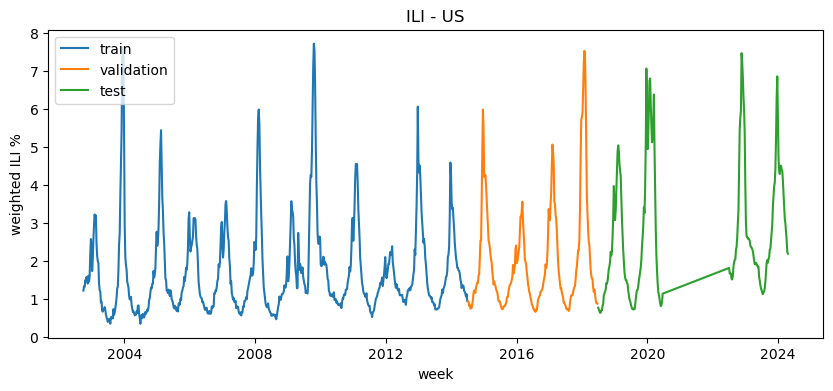

In [10]:
state = 'US'
ILI_df = load_ili_data(state)

start_val_date = pd.Timestamp('2014-07-01') #pd.Timestamp('2016-07-01') #pd.Timestamp('2016-07-01')
start_test_date = pd.Timestamp('2018-07-01') #pd.Timestamp('2019-07-01') #pd.Timestamp('2022-07-01') 

use_validation = True
if(use_validation):
    train_ind = np.where(ILI_df.index<start_val_date)[0] 
    val_ind = np.where((ILI_df.index>=start_val_date) & (ILI_df.index<start_test_date))
else:
    train_ind = np.where(ILI_df.index<start_test_date)[0]
    val_ind = []
# covid_ind = np.where((ILI_df.index>='2020-06-28') & (ILI_df.index<'2022-07-01'))
test_ind = np.where((ILI_df.index>=start_test_date))[0]

plt.figure(figsize=(10,4))
plt.plot(ILI_df.loc[ILI_df.iloc[train_ind].index,'weighted_ili'],label='train') 
if(use_validation):
    plt.plot(ILI_df.loc[ILI_df.iloc[val_ind].index,'weighted_ili'],label='validation') 
# plt.plot(ILI_df.loc[ILI_df.iloc[covid_ind].index,'weighted_ili'],label='throw (covid)') 
plt.plot(ILI_df.loc[ILI_df.iloc[test_ind].index,'weighted_ili'],label='test') 
plt.ylabel('weighted ILI %') 
plt.xlabel('week') 
plt.title('ILI - {}'.format(state)) 
plt.legend(loc=2)
plt.show()

In [11]:
ili = np.expand_dims(ILI_df['weighted_ili'].values,-1)
train_ili = ili[train_ind]
val_ili = ili[val_ind]
test_ili = ili[test_ind]

test_dates = ILI_df.index[test_ind]

scaler = MinMaxScaler() 
scaler.fit(train_ili)
train_data = scaler.transform(train_ili)
if(use_validation):
    val_data = scaler.transform(val_ili)
else:
    val_data = []
test_data = scaler.transform(test_ili)

woy = np.expand_dims(ILI_df['week'].values-1,-1) #0-index based
train_woy = None #woy[train_ind]
val_woy = None #woy[val_ind]
test_woy = None #woy[test_ind]

print(len(train_data))
print(len(val_data))
print(len(test_data))

614
208
199


In [12]:
def train_and_pred(train_data, test_data, weeks_ahead):

    training_loader  = get_data_loader(train_data, None, input_length, output_length, 
                                       weeks_ahead, batch_size, train_woy)


    #initializing the model
    model = TransformerEncoderDecoderQRModel(nhead, d_model, d_hid, nlayers, 
                                             input_length, output_length, 
                                             nfeatures, nquantiles, dropout)
    model = model.to(device)

    #training
    min_loss = sys.maxsize 
    training_loss = [] 
    if(use_validation):
        validation_loss = []
        val_loader  = get_data_loader(val_data, None, input_length, output_length, weeks_ahead, batch_size, val_woy)
        optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3) 
        (model, optimizer, min_loss, training_loss, validation_loss) = \
            run_training_loop_with_validation(50, optimizer, model, min_loss, 
                                            training_loss, validation_loss, training_loader, val_loader)
        optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4) 
        (model, optimizer, min_loss, training_loss, validation_loss) = \
            run_training_loop_with_validation(10, optimizer, model, min_loss, 
                                            training_loss, validation_loss, training_loader, val_loader)
        optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5) 
        (model, optimizer, min_loss, training_loss, validation_loss) = \
            run_training_loop_with_validation(10, optimizer, model, min_loss, 
                                            training_loss, validation_loss, training_loader, val_loader)
    else:
        # Training loop
        optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3) 
        (model, optimizer, min_loss, training_loss) = \
            run_training_loop(50, optimizer, model, min_loss, training_loss, training_loader)
        optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-4) 
        (model, optimizer, min_loss, training_loss) = \
            run_training_loop(10, optimizer, model, min_loss, training_loss, training_loader)
        optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5) 
        (model, optimizer, min_loss, training_loss) = \
            run_training_loop(10, optimizer, model, min_loss, training_loss, training_loader)

    #training progress
    plot_training_progress = True
    if(plot_training_progress):
        plt.figure()
        plt.title('Training') 
        plt.yscale('log') 
        plt.plot(training_loss, label = 'training') 
        if(use_validation):
            plt.plot(validation_loss, label = 'validation') 
        plt.ylabel('Loss') 
        plt.xlabel('Epoch') 
        plt.legend() 
        plt.show()
    
    pred_train = get_model_pred(train_data, None, model, weeks_ahead, input_length, output_length, batch_size)
    pred_test =  get_model_pred(test_data, None, model, weeks_ahead, input_length, output_length, batch_size)
    return (model, pred_train, pred_test)
    

In [13]:
def get_ili_data_and_pred(pred, ili, dates):
    pred_ili = scaler.inverse_transform(pred)
    #slice ili and test_dates to same dates as pred dates
    ili_slice = ili[(len(ili)-len(pred_ili)):]
    dates_slice = dates[(len(ili)-len(pred_ili)):]
    return (pred_ili,ili_slice,dates_slice)

In [ ]:
random.seed(1) 
torch.manual_seed(1)

max_horizon = 4
model_list = []
pred_train_list = []
pred_test_list = []
for i in range(max_horizon):
    weeks_ahead = i+1
    model1, pred_train1, pred_test1 = train_and_pred(train_data, test_data, weeks_ahead)  
    model_list.append(model1)
    pred_train_list.append(pred_train1)
    pred_test_list.append(pred_test1)

weeks_ahead=1 (length=194): WIS=0.194, Quantile loss=2.094
weeks_ahead=2 (length=193): WIS=0.327, Quantile loss=3.525
weeks_ahead=3 (length=192): WIS=0.436, Quantile loss=4.691
weeks_ahead=4 (length=191): WIS=0.529, Quantile loss=5.672
weeks_ahead=5 (length=190): WIS=0.619, Quantile loss=6.642


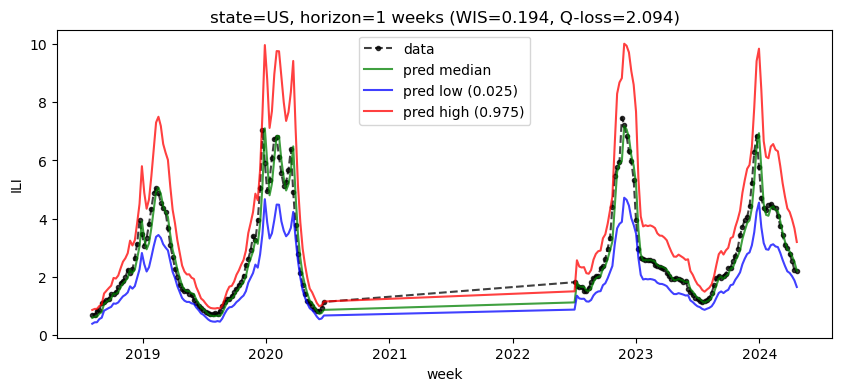

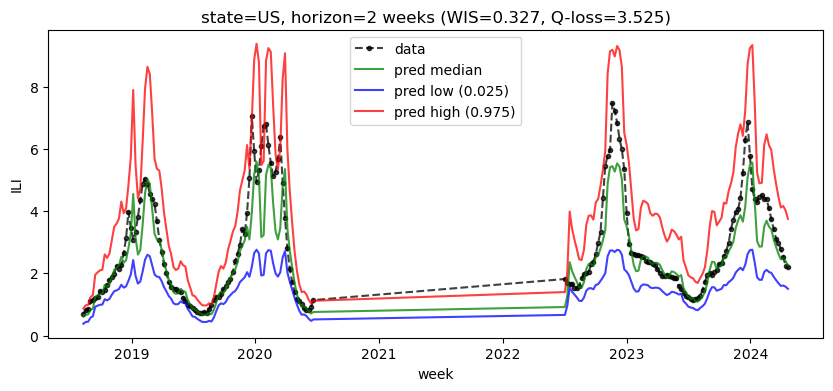

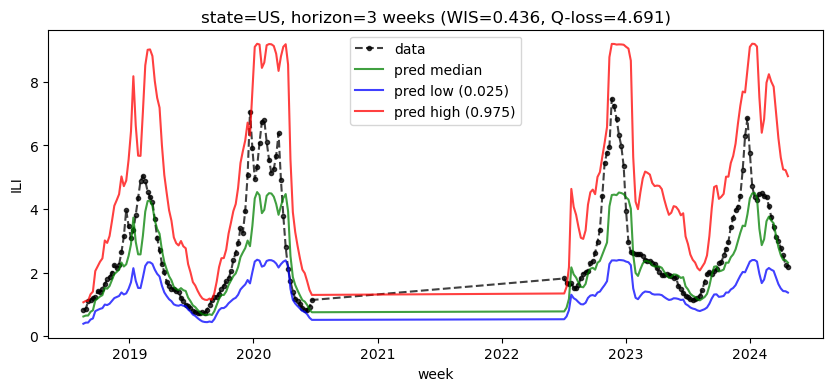

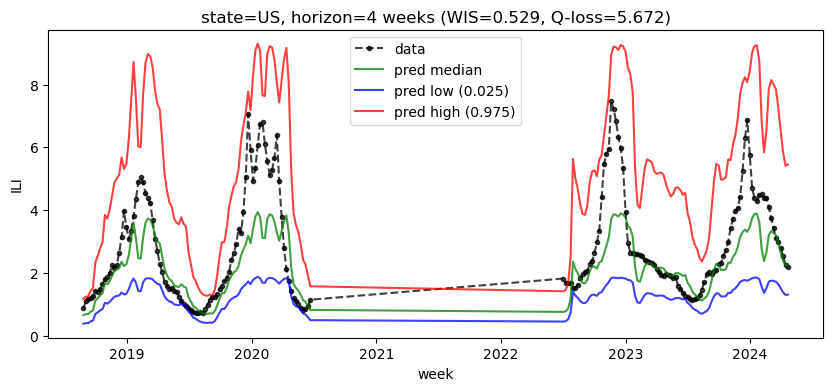

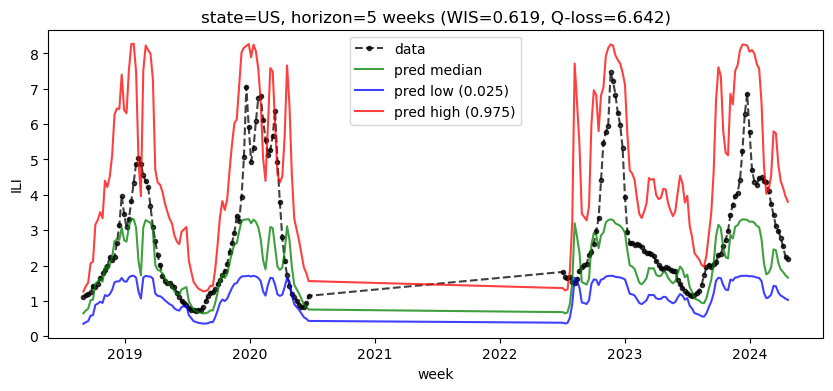

In [16]:
for i in range(max_horizon):
    weeks_ahead = i+1
    pred_test1 = pred_test_list[i]
    pred_test_ili1, test_ili1, test_dates1 = get_ili_data_and_pred(pred_test1, test_ili, test_dates)
    plot_pred_fit(pred_test_ili1, test_ili1, test_dates1, weeks_ahead, state, use_dates_index=False)